In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
sys.path.append('..')

from sbi import simulator, model

Could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


```python -m sbi.train --trainfrom=file --savepath test_weights/test --datapath data --max_epochs=50```

In [2]:
theta_samples, x_samples = simulator.load(path = '../data', dataloader = False)

sim = simulator.Simulator()
#sim(n_train = 50_000, outpath='../data')
plx, e_plx, distance = sim.plxdata[:,0], sim.plxdata[:,1], sim.plxdata[:,2]

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
max(distance)

842.8234252929688

In [4]:
def log_prior(dist):
    L = 350
    if (1 < dist < 2000):
        return np.log(dist**2 / (2*L**3)) - dist / L
    else:
        return np.inf

def log_likelihood(dist, plx, e_plx, prior = True):
    likelihood = -0.5*(np.log(e_plx) + ((1000/dist) - plx)**2/e_plx)
    prior = -log_prior(dist)
    return likelihood + prior if prior else likelihood

100%|██████████| 5000/5000 [00:05<00:00, 875.75it/s] 


256.21685791015625 258.214344154622


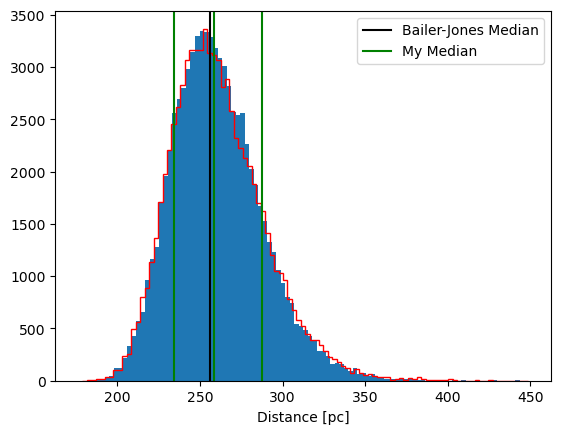

In [5]:
import emcee
import corner

i = np.random.randint(0, len(distance))

# Sampling with `emcee`
ndim, nwalkers = 1, 16
sampler_prior = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(plx[i], e_plx[i], True))
# Initialize the walkers
theta_guess = np.random.uniform(low=(1), high=(2000), size=(nwalkers, ndim))
pos = theta_guess + np.random.randn(nwalkers, ndim)
sampler_prior.run_mcmc(pos, 5000, progress=True);

# Sampling with `emcee`
ndim, nwalkers = 1, 16
sampler_naive = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(plx[i], e_plx[i], False))
# Initialize the walkers
theta_guess = np.random.uniform(low=(1), high=(2000), size=(nwalkers, ndim))
pos = theta_guess + np.random.randn(nwalkers, ndim)
sampler_naive.run_mcmc(pos, 5000, progress=True);

chain_prior=sampler_prior.get_chain(flat=True)
plt.hist(chain_prior[1000:], bins = 100)
chain_naive=sampler_naive.get_chain(flat=True)
plt.hist(chain_naive[1000:], bins = 100, histtype='step', color='red')
plt.axvline(distance[i], label="Bailer-Jones Median", c = 'k')
plt.axvline(np.percentile(chain_prior, 50), label="My Median", c = 'green')
plt.axvline(np.percentile(chain_prior, 84), c = 'green')
plt.axvline(np.percentile(chain_prior, 16), c = 'green')
plt.xlabel('Distance [pc]')
plt.legend()
print(distance[i], np.median(chain_prior))

In [6]:
torch.mean(theta_samples, axis=0)

tensor([4.0948e+04, 2.0439e+02, 1.4474e-02])

In [10]:
import corner

theta_test = np.array([15000, 50, 0.012])
x_test = sim.forward_noisy(*theta_test)
x_test_norm = (torch.Tensor(x_test) - x_samples.mean(dim=0)) / x_samples.std(dim=0)

npereader = model.load_model_from_path('../test_weights/test')
context = npereader.featurizer(x_test_norm).unsqueeze(0)
samples_test = npereader.flow.sample(num_samples=5000, context=context) * theta_samples.std(dim=0) + theta_samples.mean(dim=0)

In [11]:
x_test

array([2.00462887e+01, 7.59755864e-02, 2.03190121e-16, 3.48421423e-16,
       9.27588691e-17, 6.25037931e-16, 4.50132856e-16, 2.03163610e-16,
       1.08500785e-16, 5.80841610e-17, 5.80027817e-19, 9.89711818e-19,
       2.63994959e-19, 1.77435303e-18, 1.28265516e-18, 5.78571361e-19,
       3.07915181e-19, 1.65442938e-19])

True parameters:
temperature = 15000.0 K 
distance = 50.0 pc 
radius = 0.012 r_sun


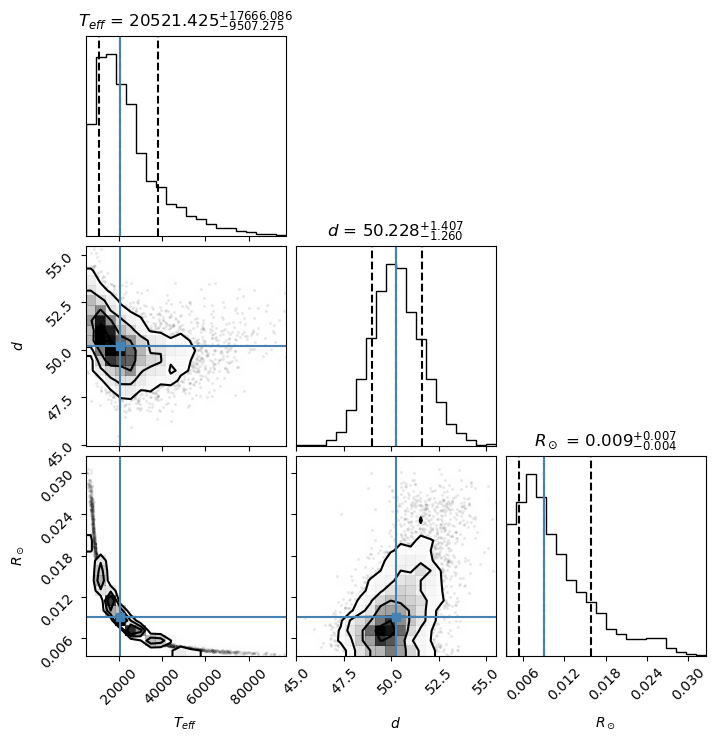

In [12]:
labels = [r"$T_{eff}$", r"$d$", r"$R_\odot$"]
best_est = np.zeros((len(labels)))
unc = []

temp_chain = samples_test[0].detach().numpy()
#temp_chain[:, 2] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

corner.corner(temp_chain, labels=labels, truths=best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12});
print(f"True parameters:\ntemperature = {theta_test[0]} K \ndistance = {theta_test[1]} pc \nradius = {theta_test[2]} r_sun")
plt.show()

## Get Real Data

In [22]:
import pyvo

def get_ngf21():
    tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
    QUERY = f"""select top 1000 *
            from \"J/MNRAS/508/3877/sdssspec\" as ngf
            join \"J/A+A/674/A33/gspc-wd\" as gspc 
            on ngf.GaiaEDR3 = gspc.GaiaDR3
            where ngf.e_TeffH is not NULL and ngf.e_loggH is not NULL and ngf.e_TeffHe is not NULL and ngf.e_loggHe is not NULL
            and RAND() < 0.01"""
    return tap_service.search(QUERY).to_table().to_pandas()

ngf21 = get_ngf21()[['GaiaDR3', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'umag',
                     'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag']]

In [24]:
ngf21

,GaiaDR3,Gmag,e_Gmag,BPmag,e_BPmag,RPmag,e_RPmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag
0,290531967521897856,19.1841,0.0043,19.7705,0.0498,18.5593,0.0279,21.840000,0.246,19.974001,0.019,19.149000,0.013,18.882000,0.016,18.752001,0.045
1,581115504716818944,18.6702,0.0034,18.6599,0.0207,18.7617,0.0285,18.495001,0.015,18.534000,0.007,18.813999,0.010,19.056999,0.015,19.340000,0.069
2,587640998851785088,18.6115,0.0035,18.6911,0.0291,18.3949,0.0321,18.952999,0.020,18.639999,0.008,18.650999,0.009,18.693001,0.011,18.785000,0.037
3,608861401469075840,18.8205,0.0035,18.8554,0.0231,18.9569,0.0421,19.089001,0.022,18.676001,0.008,18.927000,0.010,19.125999,0.014,19.375999,0.056
4,635577472440075904,18.6782,0.0033,18.7358,0.0221,18.5565,0.0341,19.129999,0.024,18.649000,0.008,18.770000,0.010,18.839001,0.014,19.028999,0.061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,4458142728599099520,18.5210,0.0033,18.5089,0.0214,18.6266,0.0262,18.739000,0.020,18.381001,0.007,18.659000,0.009,18.886000,0.014,19.044001,0.057
150,4563476938973503616,17.1652,0.0029,17.1469,0.0049,17.2007,0.0094,17.304001,0.009,17.033001,0.005,17.285000,0.006,17.492001,0.007,17.709999,0.017
151,5184589747536175104,17.9742,0.0034,17.9710,0.0259,17.9874,0.0270,17.844000,0.012,17.856001,0.006,18.200001,0.007,18.302000,0.009,18.393000,0.025
152,6340872287390064768,18.5084,0.0038,18.7026,0.0295,18.2891,0.0294,19.066000,0.019,18.608999,0.008,18.537001,0.008,18.559000,0.010,18.716999,0.033
